<a href="https://colab.research.google.com/github/snl28/HCJ/blob/main/Class_5_PixelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name: Sunil John
## SEAS 8525 Computer Vision and Generative AI
## Homework 5


PixelCNN takes longer to train because it predicts each pixel one at a time, using all the pixels before it.This makes training slow and hard to parallelize.
It also has to learn very detailed patterns across millions of pixels, which needs many epochs and lots of computation to get good results.At 15 epochs, we can expect only basic outlines or random noise, not coherent images.


Addapted from the [book](https://https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/tree/main)

This code defines two functions:

1. `sample_batch(dataset)`:
   - Takes a `dataset` object as input.
   - Retrieves a single batch from the dataset using `dataset.take(1).get_single_element()`.
   - If the batch is a tuple, it extracts the first element of the tuple.
   - Returns the batch as a NumPy array using `batch.numpy()`.

2. `display(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None)`:
   - Takes an array of `images` and optional parameters for display configuration.
   - Normalizes the pixel values of the images to the range [0, 1] if the maximum value is greater than 1.0, or to the range [-1, 1] if the minimum value is less than 0.0.
   - Creates a figure with a specified size using `plt.figure(figsize=size)`.
   - Iterates over `n` random images from the `images` array.
   - Displays each image as a subplot using `plt.subplot(1, n, i + 1)` and `plt.imshow()`.
   - Applies the specified colormap (`cmap`) and data type (`as_type`) to the displayed images.
   - Removes the axis labels and ticks using `plt.axis("off")`.
   - If `save_to` is provided, saves the figure to the specified file path and prints a message.
   - Finally, shows the plotted images using `plt.show()`.


In [ ]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 15

In [ ]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Preprocess the data
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


input_data, output_data = preprocess(x_train)

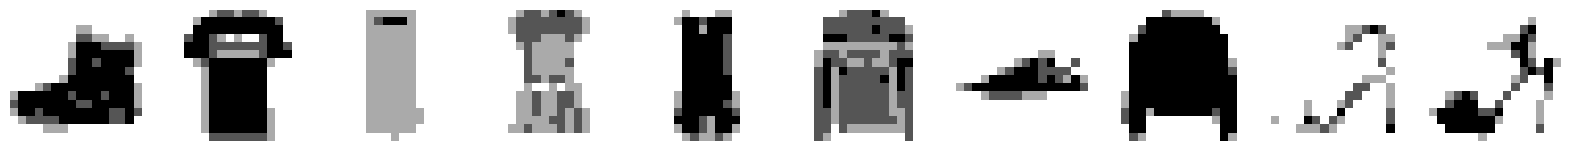

In [ ]:
# Show some items of clothing from the training set
display(input_data)

The code in the following cell defines a custom layer called `MaskedConv2D` which extends the functionality of the standard 2D convolutional layer (`layers.Conv2D`) by including masking.



1. The `MaskedConv2D` class is defined as a subclass of `layers.Layer`, indicating that it is a custom layer.

2. The `__init__` method is the constructor of the class. It takes a `mask_type` parameter and any additional keyword arguments (`**kwargs`). It calls the constructor of the parent class (`super(MaskedConv2D, self).__init__()`) and initializes the `mask_type` attribute. It also creates an instance of `layers.Conv2D` with the provided `**kwargs` and assigns it to the `conv` attribute.

3. The `build` method is called when the layer is being built. It first builds the `conv` layer to initialize its kernel variables. Then, it retrieves the shape of the kernel using `self.conv.kernel.get_shape()` and creates a mask tensor (`self.mask`) with the same shape, initialized with zeros.

4. Depending on the `mask_type`, the mask is populated with ones in specific regions:
   - For the upper half of the kernel (excluding the center row), the mask values are set to 1.0.
   - For the left half of the center row (including the center pixel), the mask values are set to 1.0.
   - If the `mask_type` is "B", the center pixel of the kernel is also set to 1.0.

5. The `call` method is invoked when the layer is called with an input tensor. It multiplies the `conv` layer's kernel with the mask using element-wise multiplication (`self.conv.kernel * self.mask`). This effectively applies the mask to the kernel, zeroing out the desired regions. Then, it calls the `conv` layer with the masked kernel and returns the output.

6. The `get_config` method is used to retrieve the configuration of the layer. In this case, it simply calls the `get_config` method of the parent class and returns the configuration.

The purpose of this `MaskedConv2D` layer is to apply a mask to the convolutional kernel, allowing only certain regions of the kernel to be active during the convolution operation. This is particularly useful in architectures like PixelCNN, where the masking ensures that each pixel in the output depends only on the pixels above and to the left of it in the input, following a specific order.

In [ ]:
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.shape # Changed to .shape
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

The code in the following cell defines a custom layer called `ResidualBlock` which implements a residual block architecture commonly used in deep neural networks. Residual blocks allow the network to learn residual functions and facilitate the training of deep networks by alleviating the vanishing gradient problem.


1. The `ResidualBlock` class is defined as a subclass of `layers.Layer`, indicating that it is a custom layer.

2. The `__init__` method is the constructor of the class. It takes a `filters` parameter, which determines the number of filters in the convolutional layers, and any additional keyword arguments (`**kwargs`). It calls the constructor of the parent class (`super(ResidualBlock, self).__init__(**kwargs)`).

3. Inside the constructor, three convolutional layers are defined:
   - `self.conv1`: A standard 2D convolutional layer (`layers.Conv2D`) with `filters // 2` filters (half the input filters), kernel size of 1, and ReLU activation.
   - `self.pixel_conv`: An instance of the `MaskedConv2D` layer (defined in the previous code snippet) with mask type "B", `filters // 2` filters (half the input filters), kernel size of 3, ReLU activation, and "same" padding.
   - `self.conv2`: Another standard 2D convolutional layer with `filters` filters (same as the input filters), kernel size of 1, and ReLU activation.

4. The `call` method is invoked when the layer is called with an input tensor. It defines the forward pass of the residual block:
   - The input tensor is passed through `self.conv1`, followed by `self.pixel_conv`, and then `self.conv2`.
   - The output of `self.conv2` is added element-wise to the original input tensor using `layers.add([inputs, x])`, creating the residual connection.
   - The result of the element-wise addition is returned as the output of the residual block.

5. The `get_config` method is used to retrieve the configuration of the layer. In this case, it simply calls the `get_config` method of the parent class and returns the configuration.

The purpose of this `ResidualBlock` is to learn residual functions by allowing the network to pass information from the input directly to the output through the residual connection. The block consists of two branches:
- The main branch applies a series of convolutional operations (conv1 → pixel_conv → conv2) to the input.
- The residual branch simply passes the input directly to the output.

The outputs of both branches are then added element-wise, enabling the network to learn the residual function. This residual connection helps in training deep networks by allowing the gradients to flow more easily through the network, mitigating the vanishing gradient problem.

The `MaskedConv2D` layer used in the `pixel_conv` ensures that the convolution operation follows a specific masking pattern, which is useful in a PixelCNN.

In [ ]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

The code below defines the architecture of a PixelCNN model using the Keras functional API.

1. `inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))`:
   - This line defines the input layer of the model using `layers.Input`.
   - The input shape is specified as `(IMAGE_SIZE, IMAGE_SIZE, 1)`, indicating that the input images have a height and width of `IMAGE_SIZE` and a single channel (grayscale).

2. `x = MaskedConv2D(mask_type="A", filters=N_FILTERS, kernel_size=7, activation="relu", padding="same")(inputs)`:
   - The input tensor is passed through a `MaskedConv2D` layer with mask type "A", `N_FILTERS` filters, a kernel size of 7, ReLU activation, and "same" padding.
   - This layer applies a masked convolution operation to the input, allowing the model to capture local dependencies.

3. `for _ in range(RESIDUAL_BLOCKS): x = ResidualBlock(filters=N_FILTERS)(x)`:
   - This loop creates a stack of `RESIDUAL_BLOCKS` residual blocks.
   - Each residual block is created using the `ResidualBlock` layer defined in the previous code snippet, with `N_FILTERS` filters.
   - The output of each residual block is assigned back to `x`, forming a deep residual network.

4. `for _ in range(2): x = MaskedConv2D(mask_type="B", filters=N_FILTERS, kernel_size=1, strides=1, activation="relu", padding="valid")(x)`:
   - This loop applies two additional `MaskedConv2D` layers with mask type "B", `N_FILTERS` filters, a kernel size of 1, stride of 1, ReLU activation, and "valid" padding.
   - These layers further process the output of the residual blocks.

5. `out = layers.Conv2D(filters=PIXEL_LEVELS, kernel_size=1, strides=1, activation="softmax", padding="valid")(x)`:
   - The final layer is a standard 2D convolutional layer (`layers.Conv2D`) with `PIXEL_LEVELS` filters, a kernel size of 1, stride of 1, softmax activation, and "valid" padding.
   - This layer produces the output of the model, representing the probability distribution over the pixel values.

6. `pixel_cnn = models.Model(inputs, out)`:
   - The `pixel_cnn` model is created using `models.Model`, specifying the input tensor (`inputs`) and the output tensor (`out`).
   - This defines the complete PixelCNN model architecture.

7. `pixel_cnn.summary()`:
   - This line prints a summary of the PixelCNN model architecture, displaying the layers, their output shapes, and the number of parameters in each layer.

The resulting `pixel_cnn` model is a deep convolutional neural network that learns to generate images pixel by pixel. The architecture consists of a stack of masked convolutional layers and residual blocks, which capture the dependencies between pixels and allow the model to generate coherent and realistic images.

The use of masked convolutions ensures that the model follows a specific order in generating pixels, where each pixel depends only on the pixels above and to the left of it in the image.

In [ ]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d (MaskedConv2D)    │ (None, 16, 16, 128)    │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ (None, 16, 16, 128)    │        53,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_1                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_3                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_4                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d_6 (MaskedConv2D)  │ (None, 16, 16, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d_7 (MaskedConv2D)  │ (None, 16, 16, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 4)      │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,460 (1.17 MB)

 Trainable params: 307,460 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [ ]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(
            generated_images,
            save_to="/content/images/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=10)

In [ ]:
!mkdir ./images

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6289
Saved to /content/images/generated_img_000.png


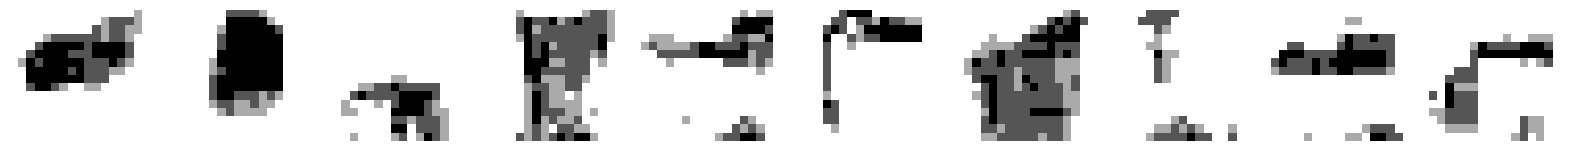

469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - loss: 0.6286
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4056
Saved to /content/images/generated_img_001.png


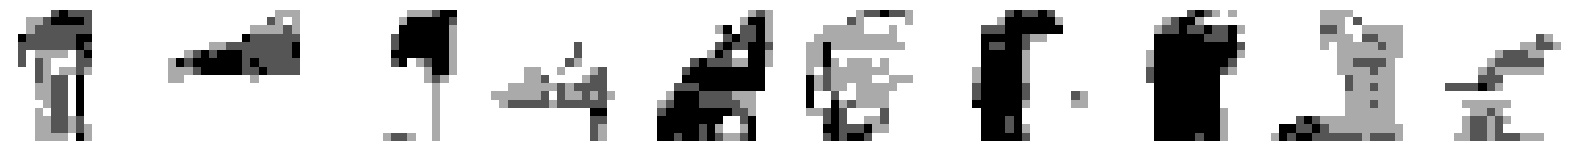

469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - loss: 0.4056
Epoch 3/15
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3906
Saved to /content/images/generated_img_002.png


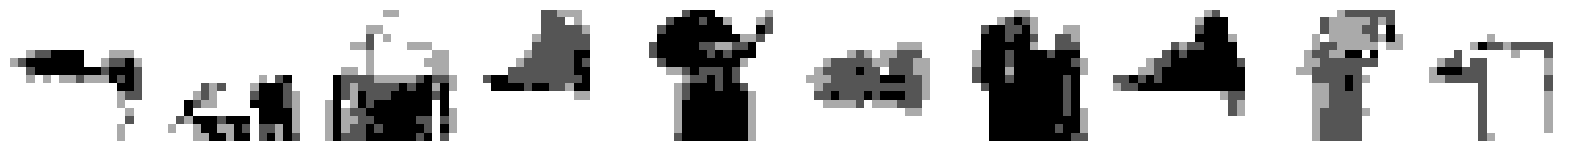

469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 59ms/step - loss: 0.3905
Epoch 4/15
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3824
Saved to /content/images/generated_img_003.png


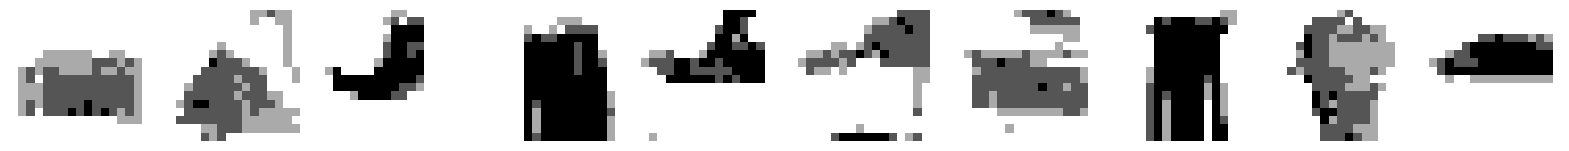

469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - loss: 0.3824
Epoch 5/15
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3772
Saved to /content/images/generated_img_004.png


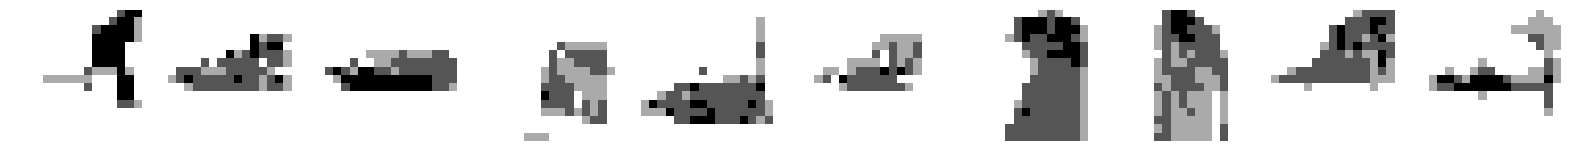

469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - loss: 0.3772
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3726
Saved to /content/images/generated_img_005.png


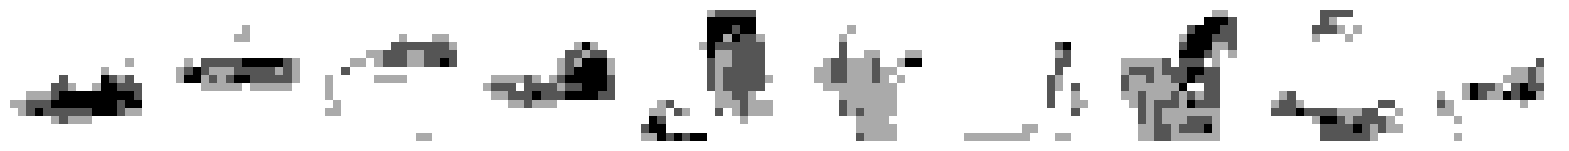

469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - loss: 0.3726
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3689
Saved to /content/images/generated_img_006.png


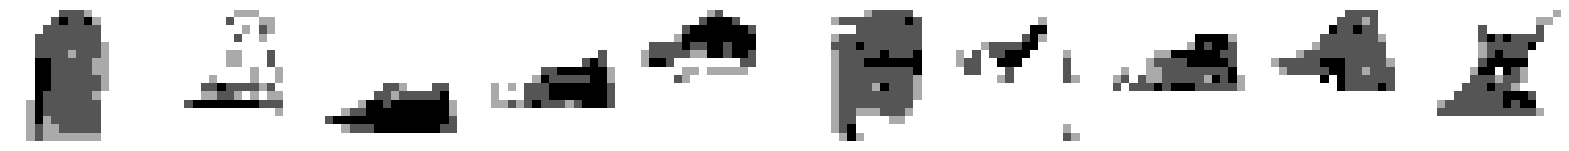

469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - loss: 0.3689
Epoch 8/15
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3645
Saved to /content/images/generated_img_007.png


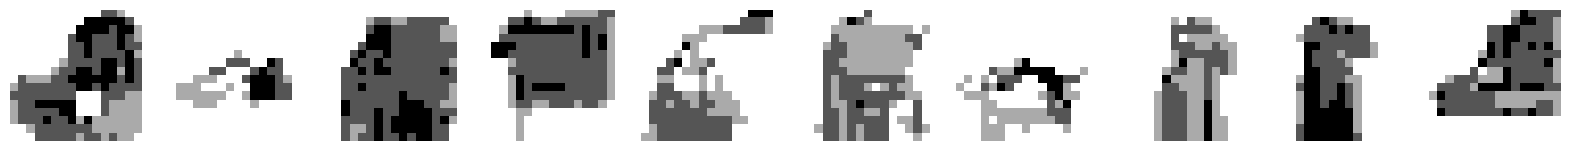

469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - loss: 0.3645
Epoch 9/15
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3634
Saved to /content/images/generated_img_008.png


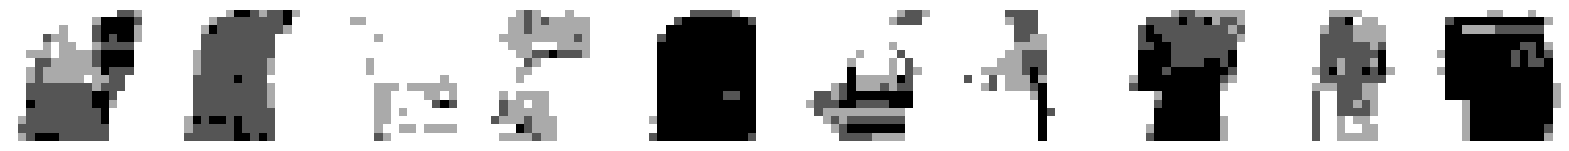

469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 60ms/step - loss: 0.3634
Epoch 10/15
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3612
Saved to /content/images/generated_img_009.png


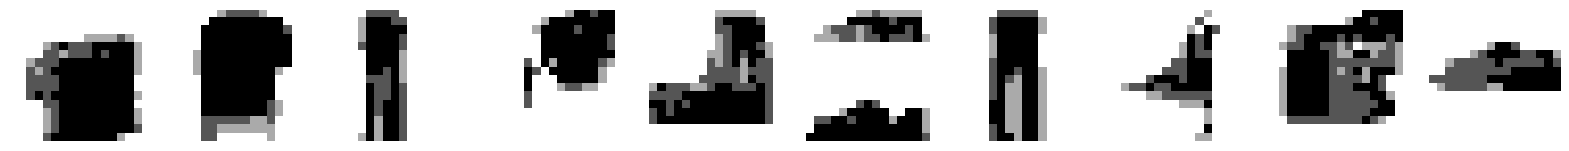

469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - loss: 0.3612
Epoch 11/15
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3588
Saved to /content/images/generated_img_010.png


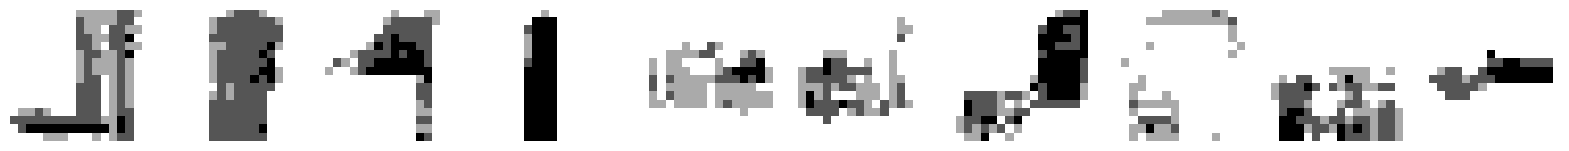

469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - loss: 0.3588
Epoch 12/15
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3576
Saved to /content/images/generated_img_011.png


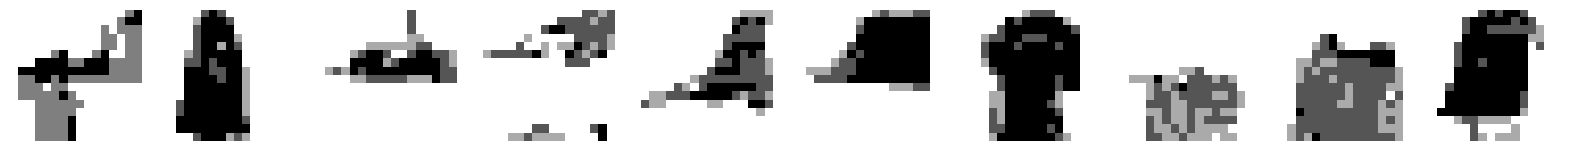

469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - loss: 0.3576
Epoch 13/15
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3561
Saved to /content/images/generated_img_012.png


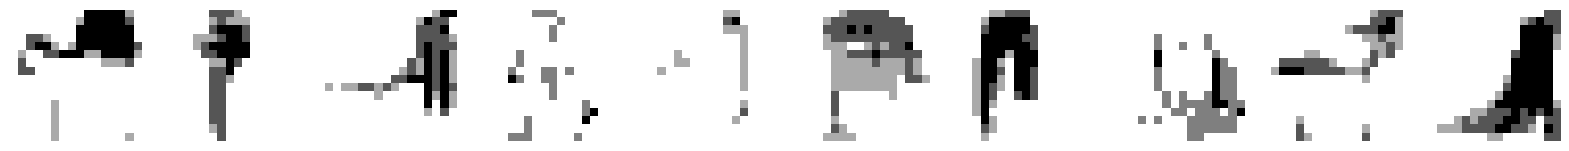

469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - loss: 0.3561
Epoch 14/15
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3548
Saved to /content/images/generated_img_013.png


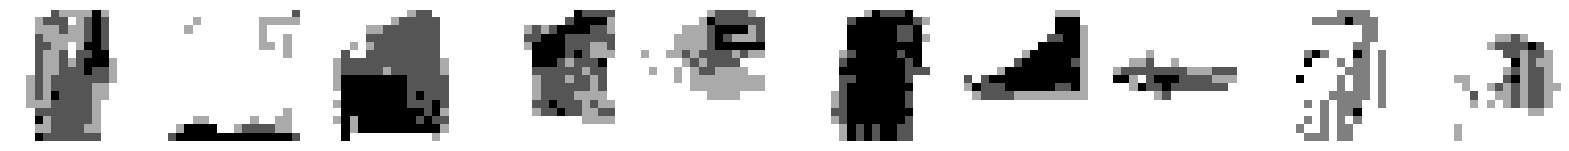

469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - loss: 0.3548
Epoch 15/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3532
Saved to /content/images/generated_img_014.png


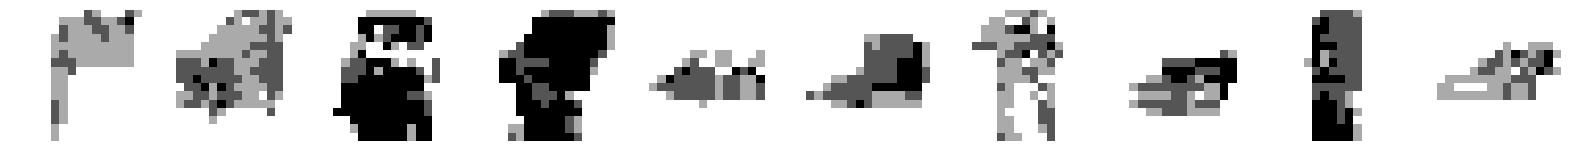

469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - loss: 0.3532


In [ ]:
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)